In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import torch
import scanpy as sc
import muon as mu
import anndata
import mudata
import pandas as pd
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
DATA_DIR = "/media/yob/nacho_stuff/prostate_cancer/Integration/MVAE-PoE/OtF-prostate/data/"
mdata = mu.read(DATA_DIR + "mdata_preprocessed_final_filtered.h5mu")
mdata

MuData object with n_obs × n_vars = 42475 × 31460
  obs:	'sample', 'tissue', 'patient', 'ann', 'imagerow', 'imagecol'
  2 modalities
    rna:	42475 x 18950
      obs:	'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'size_factors', 'sample', 'type', 'patient', 'ann', 'tissue', 'imagerow', 'imagecol'
      obsm:	'spatial'
      layers:	'counts', 'scran_normalization', 'spotclean'
    msi:	42475 x 12510
      obs:	'ST_barcode', 'sample', 'tissue', 'patient', 'ann', 'imagerow', 'imagecol'
      obsm:	'spatial'

In [5]:
msi = mdata["msi"]
msi

AnnData object with n_obs × n_vars = 42475 × 12510
    obs: 'ST_barcode', 'sample', 'tissue', 'patient', 'ann', 'imagerow', 'imagecol'
    obsm: 'spatial'

# Without LISI loss (vanilla VAE, total loss = MSE)

In [11]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)

In [7]:
from src.types import TrainParams
train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, 
                           add_lisi_loss=False, params_file="vae_params_no_lisi")

In [ ]:
torch.set_num_threads(16)
model_no_lisi = VAE(mdata["msi"].copy(), model_params)

# Training:

# from src.vae.train import train_vae
# hist = train_vae(model, msi, train_params)

In [12]:
# Load state
model_dict = torch.load('mvae_params/vae_params_no_lisi_20230319-171734.pt', map_location='cuda')
model_no_lisi.load_state_dict(model_dict)

<All keys matched successfully>

## Diagnostics

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:11<00:00, 27.80it/s]
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c

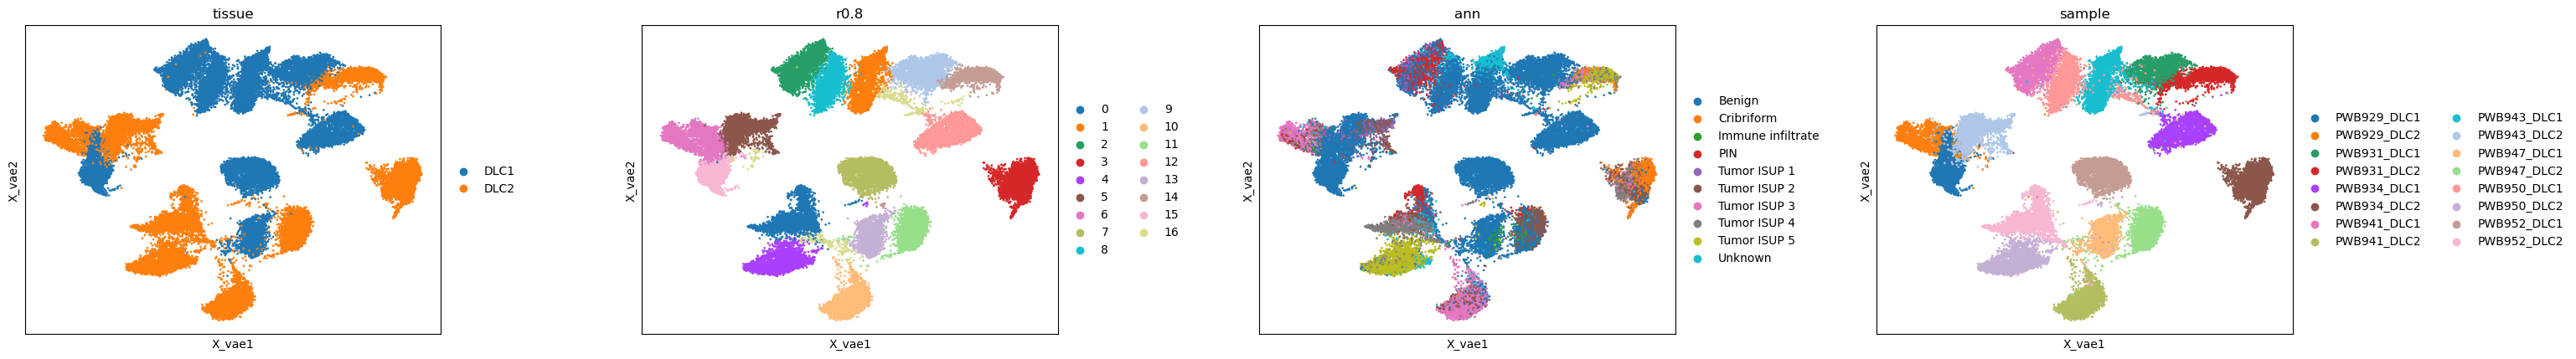

In [14]:
from src.vae.diagnostics import plot_embedding
plot_embedding(model_no_lisi, msi, train_params)

In [15]:
from src.vae.diagnostics import classification_performance

# Random Forest Classification
classification_performance(model_no_lisi, msi, "ann", train_params)

0.7447385317828351

In [16]:
from src.vae.diagnostics import batch_integration

# Mean LISI value across cells, LISI =~ from how many different batches a cell has neighbors
batch_integration(model_no_lisi, msi, train_params)

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.70it/s]


tensor(1.1285, device='cuda:0')

# With LISI loss (total loss = MSE + 1/mean(LISI))

In [18]:
from src.types import TrainParams
lisi_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, params_file="vae_lisi")

In [19]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)
msi = mdata["msi"].copy()

model_lisi = VAE(msi, model_params)
model_lisi

VAE(
  (sampling): SamplingLayers(
    (mean): Sequential(
      (0): Linear(in_features=300, out_features=100, bias=True)
      (1): Dropout(p=0.3, inplace=False)
    )
    (logvar): Sequential(
      (0): Linear(in_features=300, out_features=100, bias=True)
      (1): Dropout(p=0.3, inplace=False)
    )
  )
  (encoder): FullyConnectedLayers(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12510, out_features=300, bias=True)
        (1): BatchNorm1d(300, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
        (1): BatchNorm1d(300, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): FullyConnectedLayers(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in

In [21]:
# Training

# from src.vae.train import train_vae
# hist = train_vae(model, msi, lisi_params)

# Load state
model_dict = torch.load('mvae_params/vae_lisi_20230319-230753.pt', map_location='cuda')
model_lisi.load_state_dict(model_dict)

<All keys matched successfully>

## Diagnostics

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.33it/s]
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c

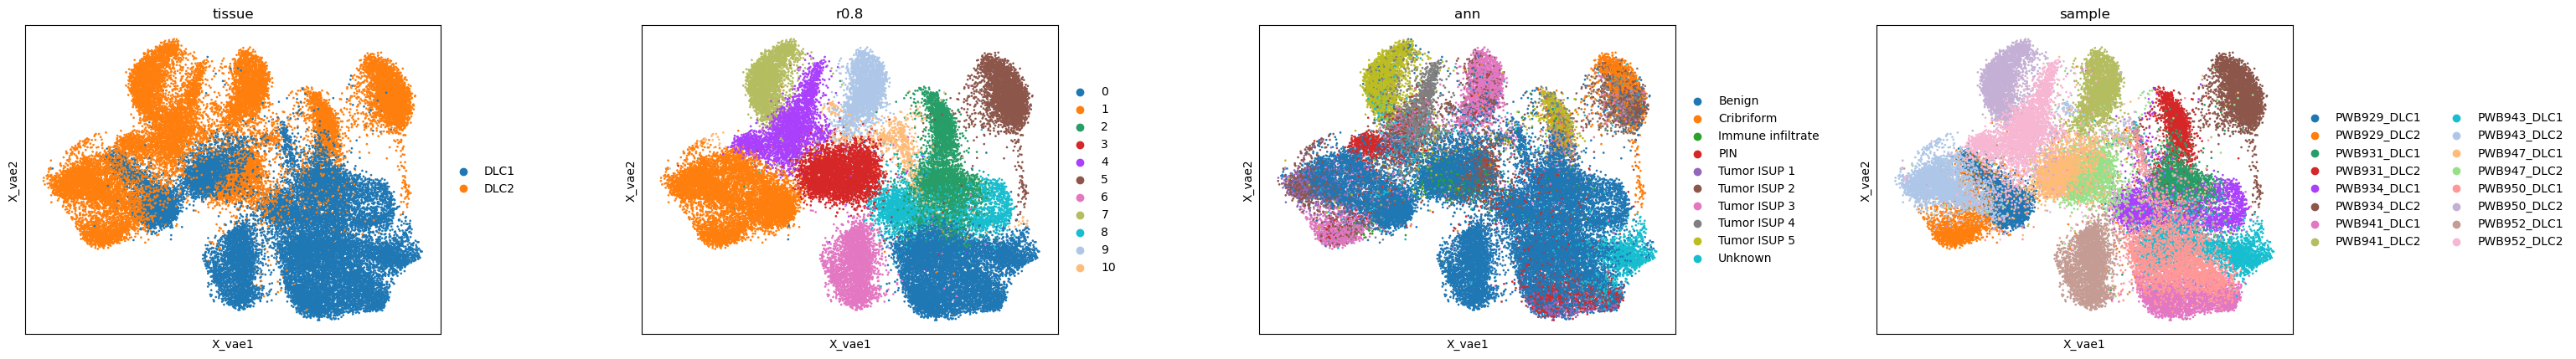

In [22]:
plot_embedding(model_lisi, msi, train_params)

In [23]:
# Random Forest Classification
score, rfc = classification_performance(model_lisi, msi, "ann", train_params)
score

0.6895198687308268

In [24]:
batch_integration(model_lisi, msi, train_params)

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.70it/s]


tensor(1.9593, device='cuda:0')

# With LISI loss (total loss = MSE + N/mean(LISI^2))

In [27]:
from src.types import TrainParams
lisi_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, 
                          add_lisi_loss=True, params_file="vae_lisi_pow2")

In [26]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)
msi = mdata["msi"].copy()

model_lisi_pow2 = VAE(msi, model_params)

In [32]:
# from src.vae.train import train_vae
# hist = train_vae(model_lisi_pow2, msi, lisi_params)

# Load state
model_dict = torch.load('mvae_params/vae_lisi_pow2_20230321-162732.pt', map_location='cuda')
model_lisi_pow2.load_state_dict(model_dict)

<All keys matched successfully>

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.18it/s]
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c

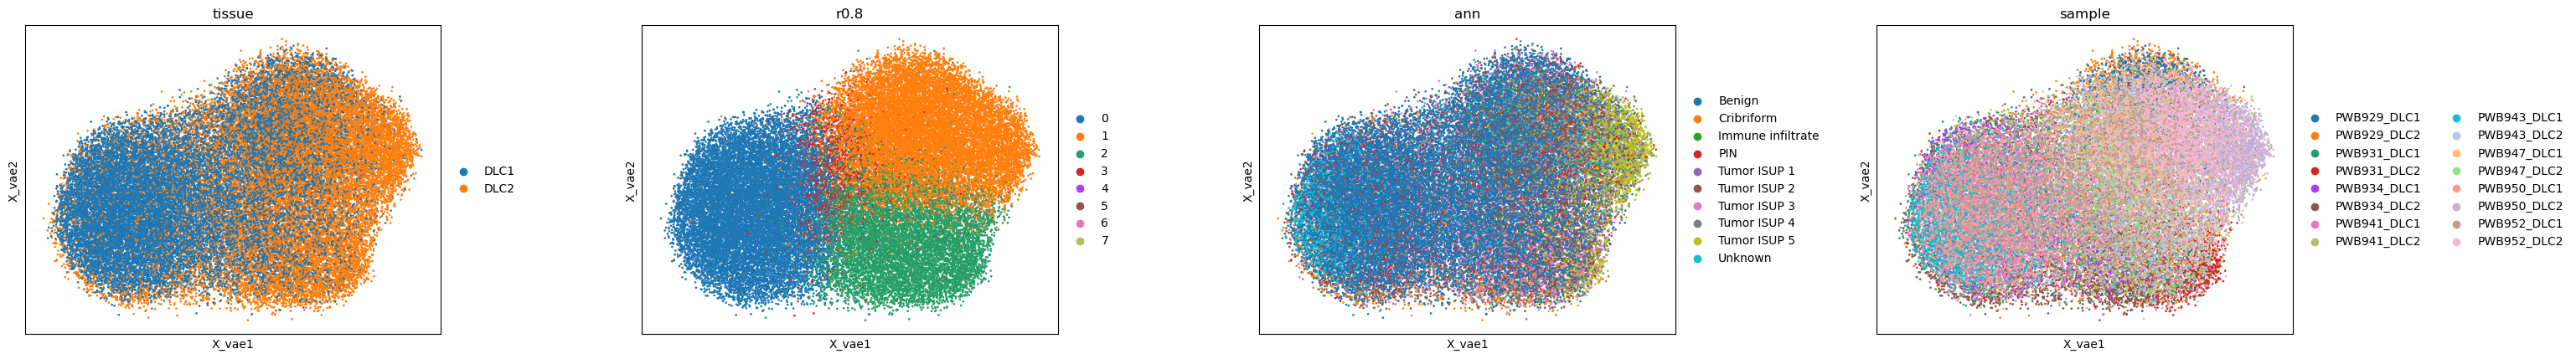

In [33]:
plot_embedding(model_lisi_pow2, msi, lisi_params)

In [34]:
score, rfc = classification_performance(model_lisi_pow2, msi, "ann", lisi_params)
score

0.47898979810230435

In [35]:
batch_integration(model_lisi_pow2, msi, lisi_params)

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.46it/s]


tensor(3.8472, device='cuda:0')

# With LISI loss (total loss = MSE + 1/mean(LISI^2))

In [46]:
from src.types import TrainParams
lisi_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, 
                          add_lisi_loss=True, params_file="vae_lisi_1_pow2")

In [42]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)
msi = mdata["msi"].copy()

model_lisi_1_pow2 = VAE(msi, model_params)

In [43]:
# from src.vae.train import train_vae
# hist = train_vae(model_lisi_1_pow2, msi, lisi_params)

model_dict = torch.load('mvae_params/vae_lisi_1_pow2_20230321-172258.pt', map_location='cuda')
model_lisi_1_pow2.load_state_dict(model_dict)

<All keys matched successfully>

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 19.98it/s]
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c

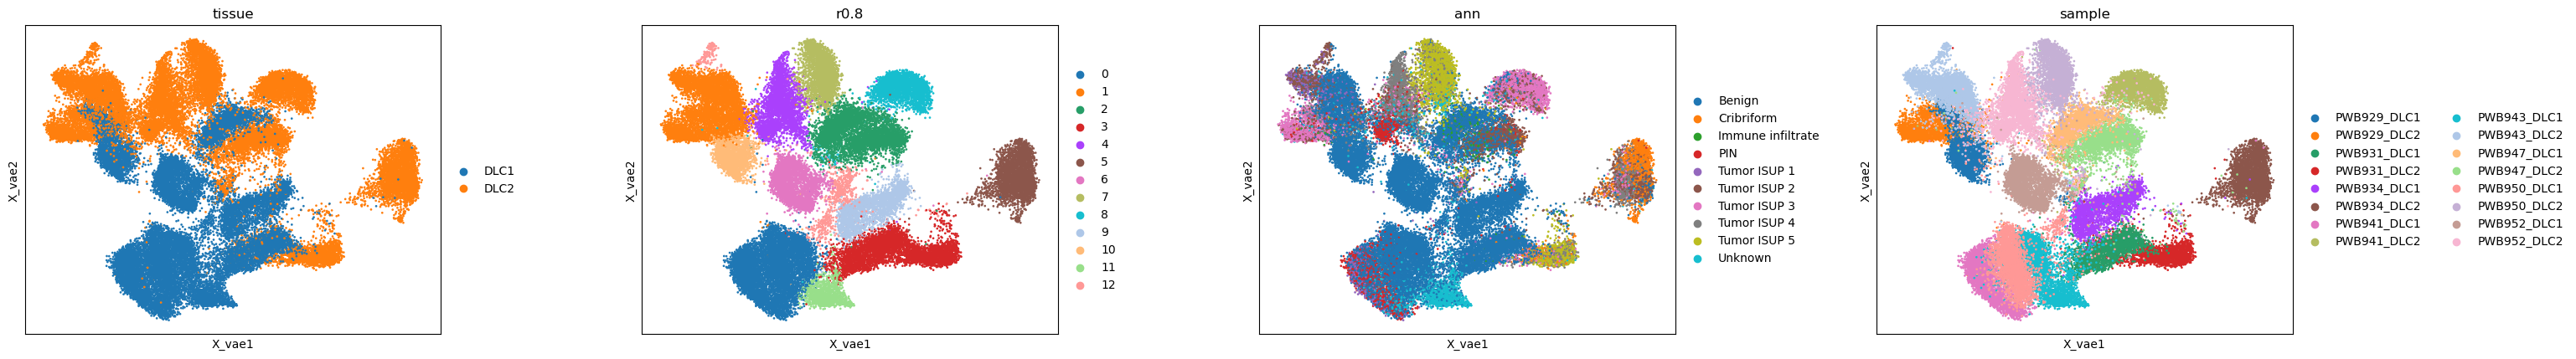

In [47]:
plot_embedding(model_lisi_1_pow2, msi, lisi_params)

In [45]:
score, rfc = classification_performance(model_lisi_1_pow2, msi, "ann", lisi_params)
score

0.7097096382963545

In [48]:
batch_integration(model_lisi_1_pow2, msi, lisi_params)

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 20.71it/s]


tensor(1.5659, device='cuda:0')

# With LISI loss (total loss = MSE + 1/mean(LISI^2), k-nn with k=3 * 50)

In [6]:
from src.types import TrainParams
lisi_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, 
                          add_lisi_loss=True, params_file="vae_lisi_3batch")

In [27]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)
msi = mdata["msi"].copy()

model_lisi_batch = VAE(msi, model_params)

In [28]:
from src.vae.train import train_vae
hist = train_vae(model_lisi_batch, msi, lisi_params)


/media/gambino/students_workdir/anna/OtF-prostate/src/vae/dataloader.py:49: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[BATCH_KEY] = pd.Categorical(
/media/gambino/students_workdir/anna/OtF-prostate/src/vae/dataloader.py:49: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[BATCH_KEY] = pd.Categorical(
100%|██████████████████████████████████████████████████████████████████████████| 266/266 [01:59<00:00,  2.22it/s]

EarlyStopping (epoch: 1): train loss improved to 0.015846394845287264



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:24<00:00,  2.73it/s]

EarlyStopping (epoch: 1): valid loss improved to 0.9819443955350278



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [01:55<00:00,  2.31it/s]

EarlyStopping (epoch: 2): train loss improved to 0.005767311105803927



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:25<00:00,  2.66it/s]

EarlyStopping (epoch: 2): valid loss improved to 0.7033666826006192



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:25<00:00,  2.59it/s]

EarlyStopping (epoch: 3): valid loss improved to 0.6012641502850091



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:25<00:00,  2.59it/s]

EarlyStopping (epoch: 4): valid loss improved to 0.5331897530982743



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.56it/s]

EarlyStopping (epoch: 5): valid loss improved to 0.5017326416364357



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:25<00:00,  2.59it/s]

EarlyStopping (epoch: 6): valid loss improved to 0.4841827296498996



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.56it/s]

EarlyStopping (epoch: 7): valid loss improved to 0.4723384380340576



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.54it/s]

EarlyStopping (epoch: 9): valid loss improved to 0.45680055956342325



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.53it/s]

EarlyStopping (epoch: 11): valid loss improved to 0.4421002006352837



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 12): train loss hasn't improved: 0.0036637534212546883. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.18it/s]

EarlyStopping (epoch: 13): train loss hasn't improved: 0.0036360335383364703. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.18it/s]

EarlyStopping (epoch: 14): train loss hasn't improved: 0.003611543129969513. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.19it/s]

EarlyStopping (epoch: 15): train loss hasn't improved: 0.003596902152346891. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.19it/s]

EarlyStopping (epoch: 16): train loss hasn't improved: 0.003580052520051432. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.18it/s]

EarlyStopping (epoch: 17): train loss hasn't improved: 0.0035604593892740177. Stopping.



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.53it/s]

EarlyStopping (epoch: 17): valid loss improved to 0.4308665221306815



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.18it/s]

EarlyStopping (epoch: 18): train loss hasn't improved: 0.0035502025499071633. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.18it/s]

EarlyStopping (epoch: 19): train loss hasn't improved: 0.003542695981639494. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:03<00:00,  2.15it/s]

EarlyStopping (epoch: 20): train loss hasn't improved: 0.003531678488424345. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 21): train loss hasn't improved: 0.003527223513959926. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.18it/s]

EarlyStopping (epoch: 22): train loss hasn't improved: 0.003513198833980583. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.19it/s]

EarlyStopping (epoch: 23): train loss hasn't improved: 0.0035101817566693147. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 24): train loss hasn't improved: 0.0035054859824219897. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:01<00:00,  2.18it/s]

EarlyStopping (epoch: 25): train loss hasn't improved: 0.00350014524311792. Stopping.



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.57it/s]

EarlyStopping (epoch: 25): valid loss improved to 0.4200441152302187



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 26): train loss hasn't improved: 0.00349244180411153. Stopping.



 49%|████████████████████████████████████▍                                     | 131/266 [01:00<01:01,  2.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 34): train loss hasn't improved: 0.003469619472423955. Stopping.



100%|██████████████████████████████████████████████████████████████████████████| 266/266 [02:02<00:00,  2.17it/s]

EarlyStopping (epoch: 35): train loss hasn't improved: 0.0034708187168243703. Stopping.



100%|████████████████████████████████████████████████████████████████████████████| 67/67 [00:26<00:00,  2.56it/s]

EarlyStopping (epoch: 35): valid loss hasn't improved: 0.41891161986251374. Stopping.


100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:12<00:00, 25.96it/s]
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c

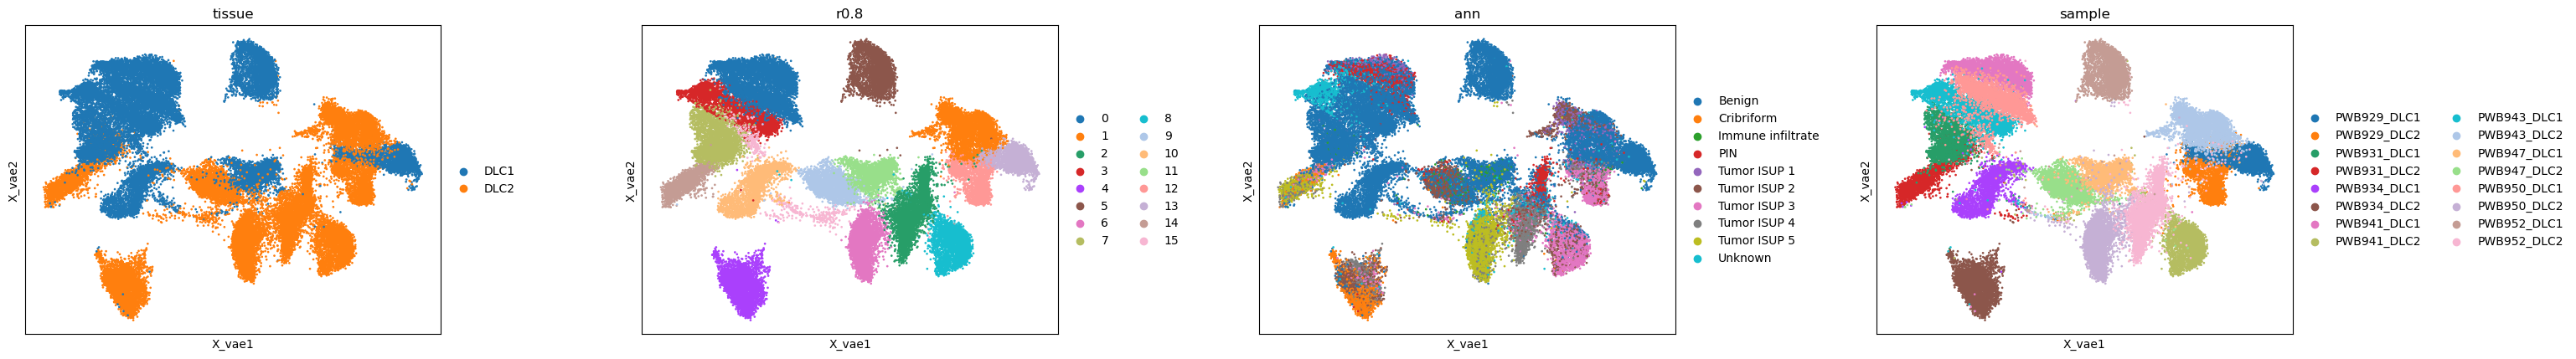

In [30]:
from src.vae.diagnostics import plot_embedding

plot_embedding(model_lisi_batch, msi, lisi_params)

In [31]:
from src.vae.diagnostics import classification_performance

classification_performance(model_lisi_batch, msi, "ann", lisi_params)

(0.7276164657201969, RandomForestClassifier())

In [34]:
from src.vae.diagnostics import batch_integration

# for comparison with previous models, here LISI is run again with K=3*30, not K=3*50
batch_integration(model_lisi_batch, msi, lisi_params)

100%|██████████████████████████████████████████████████████████████████████████| 332/332 [00:16<00:00, 19.98it/s]


tensor(1.3608, device='cuda:0')